# Photo classification with deep learning - Google Photos classification

###**1.Import Libraries/Dataset**


##### a.Import the required libraries and the dataset (use Google Drive if required).

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [2]:
(ds_train,ds_test), info = tfds.load('imagenette/160px-v2', split=['train','validation'],as_supervised=True, shuffle_files=True, with_info=True)

##### b. Check the GPU available (recommended-use free GPU provided by Google Colab).

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!nvidia-smi

Sun May 23 17:09:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    60W / 149W |    124MiB / 11441MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **2.Data Visualization and augmentation**

#### a.Plot at least two samples from each class of the dataset (use matplotlib/seaborn/any other library).

In [5]:
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))
class_names=info.features['label'].names

Num classes: 10
Class names: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


In [6]:
dsv = ds_train.take(0)
for name in info.features['label'].names:
  dsv=dsv.concatenate(ds_train.take(50).filter(lambda image, label: label == info.features["label"].str2int(name)).take(2))

In [7]:
df = tfds.as_dataframe(ds_train.take(50),info)

In [8]:

df_2 = df.groupby('label', as_index=False).head(2).sort_values('label')

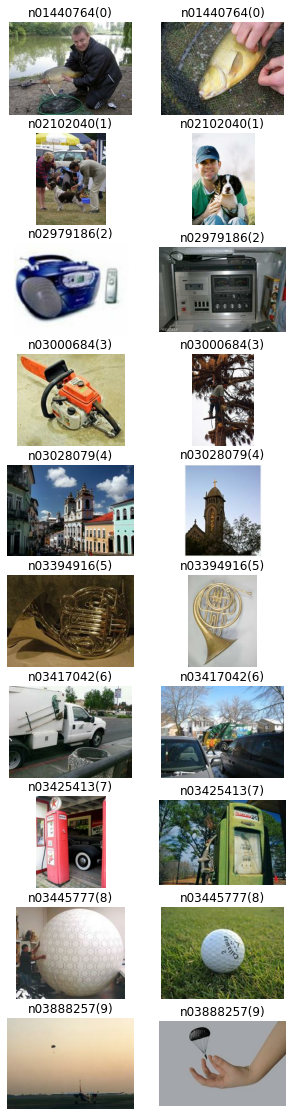

In [9]:
plt.figure(figsize=(5, 20))
i=1
for idx,row in df_2.iterrows():
  ax = plt.subplot(10, 2, i)
  plt.imshow(row['image'].astype("uint8"))
  plt.title(class_names[row['label']]+"({})".format(row['label']))
  plt.axis("off")
  i=i+1


#### b. Apply rotation and height shift augmentation (horizontal_flip, width_shift_range)to the dataset separately. Print the augmented image and the original image for each class and each augmentation.

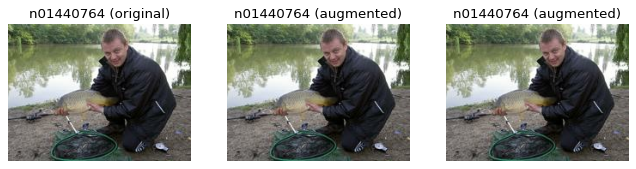

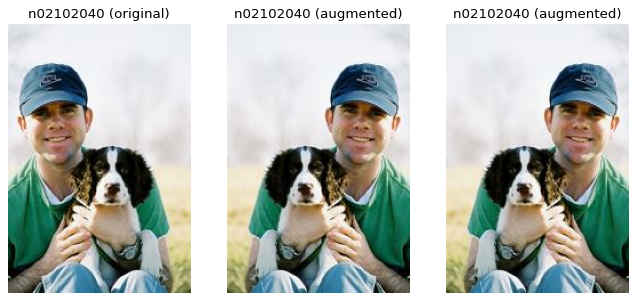

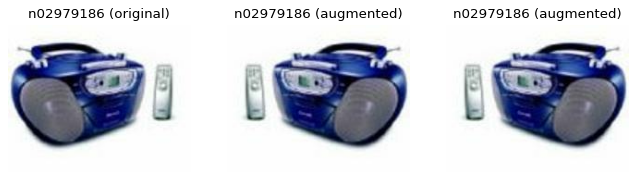

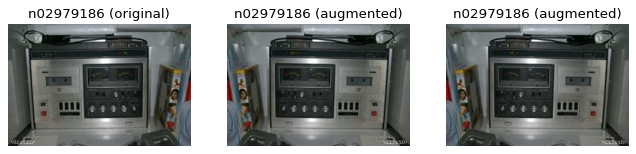

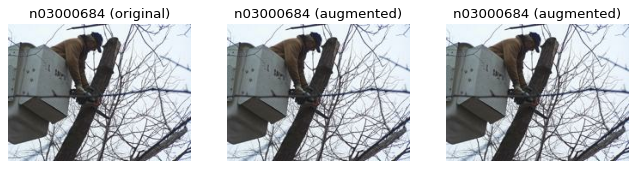

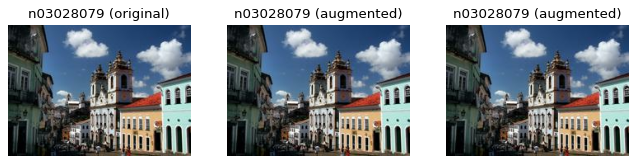

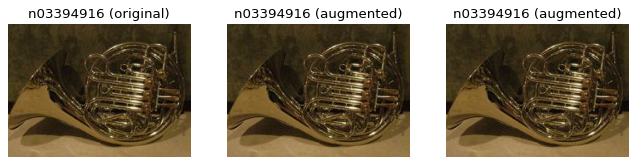

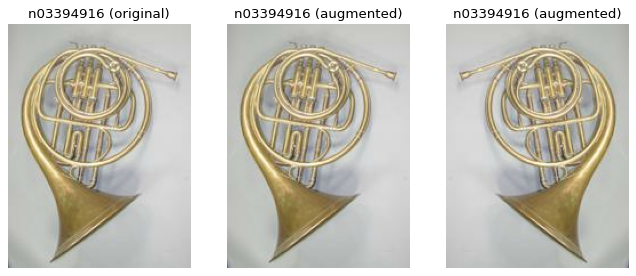

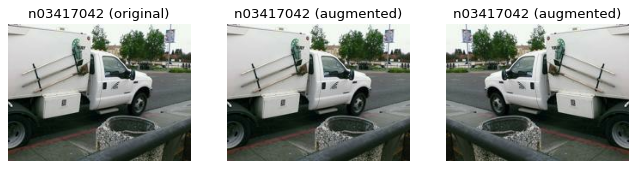

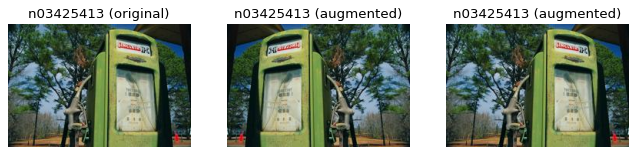

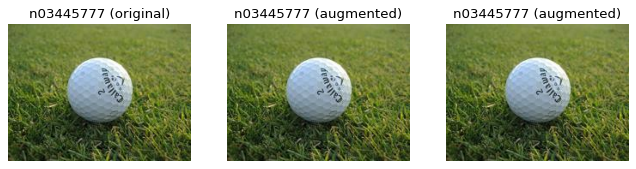

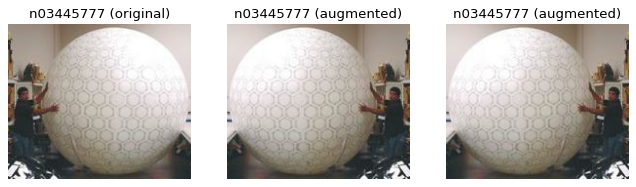

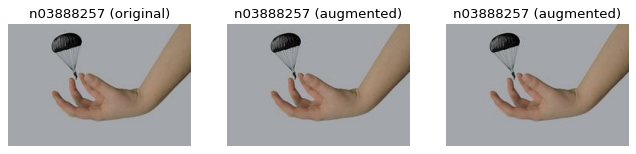

In [10]:
for image,label in dsv:
    figure(figsize=(10, 10), dpi=80)
    data = tf.keras.preprocessing.image.img_to_array(image)
    samples = np.expand_dims(data, 0)
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)
    it = datagen.flow(samples)

    plt.subplot(131)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label]+ " (original)")
    plt.axis("off")

    plt.subplot(132)
    batch = it.next()
    aug_img = batch[0].astype('uint8')
    plt.imshow(aug_img)
    plt.title(class_names[label]+ " (augmented)")
    plt.axis("off")

    plt.subplot(133)
    batch = it.next()
    aug_img = batch[0].astype('uint8')
    plt.imshow(aug_img)
    plt.title(class_names[label]+ " (augmented)")
    plt.axis("off")

    plt.show()

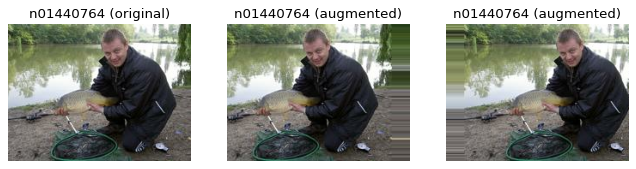

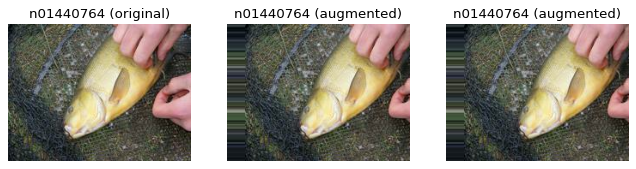

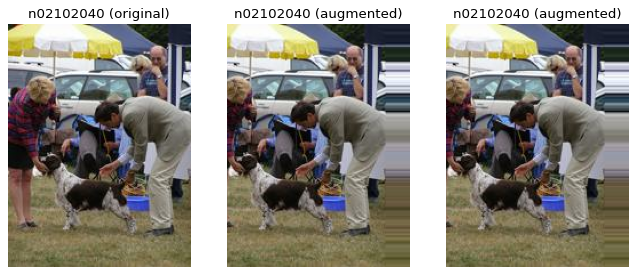

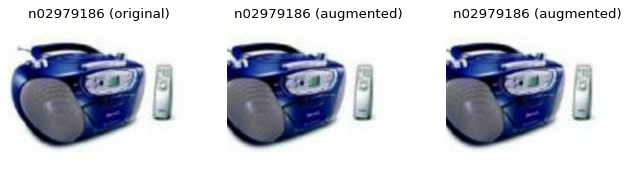

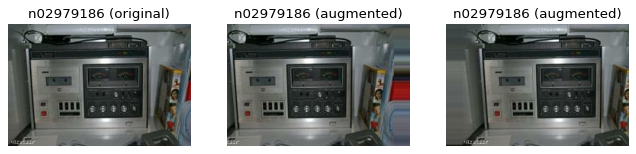

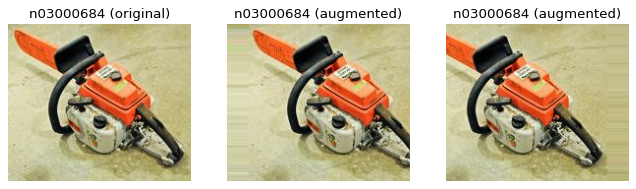

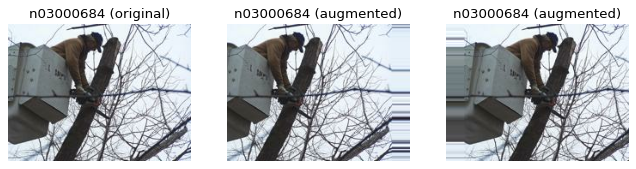

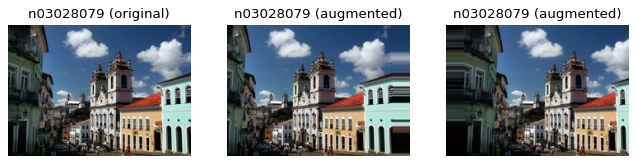

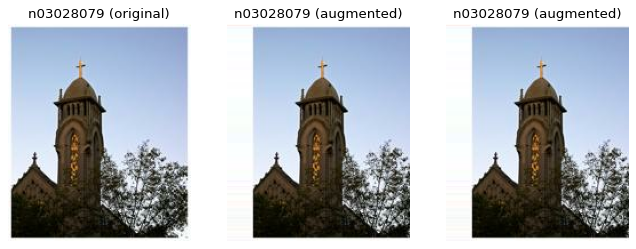

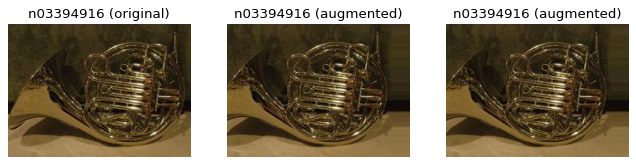

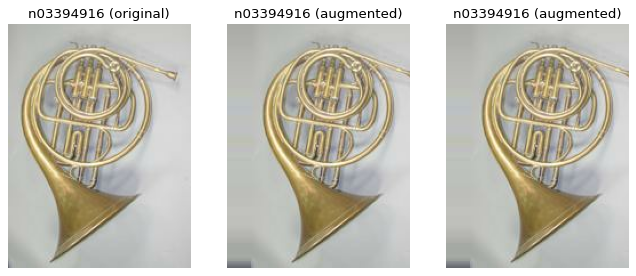

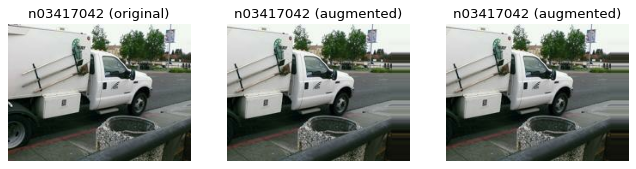

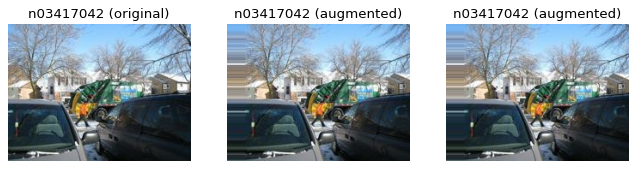

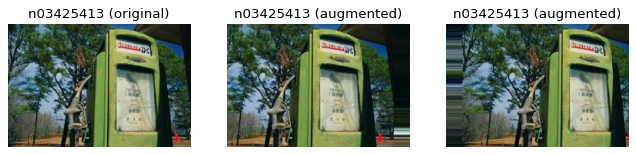

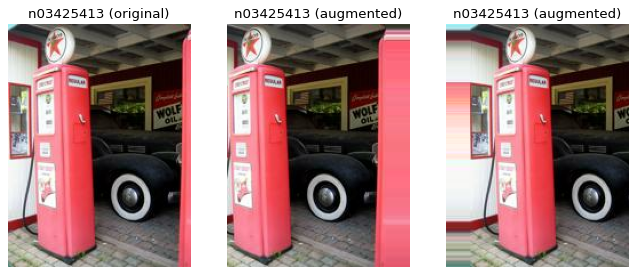

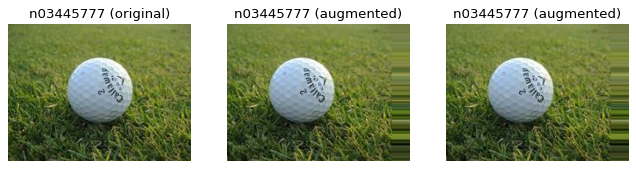

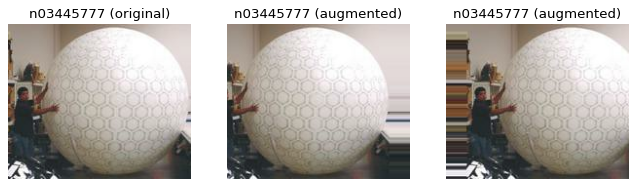

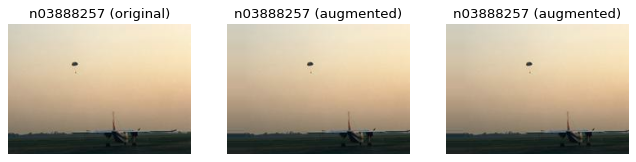

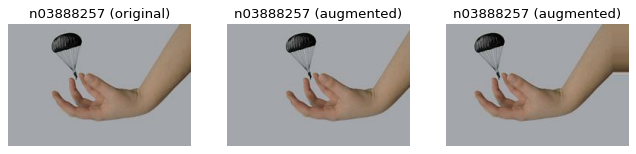

In [11]:
for image,label in dsv:
    figure(figsize=(10, 10), dpi=80)
    data = tf.keras.preprocessing.image.img_to_array(image)
    samples = np.expand_dims(data, 0)
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=[-20, 20])
    it = datagen.flow(samples)

    plt.subplot(131)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label]+ " (original)")
    plt.axis("off")

    plt.subplot(132)
    batch = it.next()
    aug_img = batch[0].astype('uint8')
    plt.imshow(aug_img)
    plt.title(class_names[label]+ " (augmented)")
    plt.axis("off")

    plt.subplot(133)
    batch = it.next()
    aug_img = batch[0].astype('uint8')
    plt.imshow(aug_img)
    plt.title(class_names[label]+ " (augmented)")
    plt.axis("off")

    plt.show()

#### c.Bring the train and test data in the required format.

#### d.Print the shapes of train and test data.

In [12]:
ds_train
tf.data.experimental.cardinality(ds_train).numpy()

9469

In [13]:
info.features['image'].shape

(None, None, 3)

In [14]:
for image, label in ds_train.take(1):
    print("Image shape for train data: ", image.numpy().shape)

Image shape for train data:  (160, 213, 3)


In [15]:
for image, label in ds_test.take(1):
    print("Image shape for test data: ", image.numpy().shape)

Image shape for test data:  (160, 189, 3)


In [16]:
info.splits['train'].num_examples, info.splits['validation'].num_examples

(9469, 3925)

In [17]:
IMG_SIZE = 160

def processing_img(img, lbl, img_shape=IMG_SIZE):
  img = tf.image.resize(img,[img_shape, img_shape])
  return tf.cast(img,tf.float32)/255.,lbl

def normalize_img(image, label):
  img = tf.image.resize(image,[IMG_SIZE, IMG_SIZE])
  return tf.cast(image,tf.float32)/255.,label

ds_train = ds_train.map(
    processing_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(info.splits['train'].num_examples)
ds_train = ds_train.batch(16)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
ds_test = ds_test.map(
    processing_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(16)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

### 3.Model Building

> a.Sequential Model layers-Use AT LEAST 3 hiddenlayers with appropriate inputfor each. Choose the best number for hidden units and give reasons.

> b.Add L2 regularization to all the layers.

> c.Add one layer of dropout at the appropriate position and give reasons.

> d.Choose the appropriate activation function for all the layers.

> e.Print the model summary.



In [19]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_SIZE, 
                                                              IMG_SIZE,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
   tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
   tf.keras.layers.experimental.preprocessing.RandomFlip(),
  ]
)

In [20]:
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001)),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001)),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001)),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001)),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001)),
  tf.keras.layers.Dense(10,activation='softmax')
])

Dropout of 10% is added after flatten layer as not evrything(like backgroung and othe noise) in image represent the class.

In [21]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
flatten (Flatten)            (None, 76800)             0         
_________________________________________________________________
dropout (Dropout)            (None, 76800)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               9830528   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

### 4.Model Compilation(0.25 mark)
>a.Compile the model with the appropriate loss function.

>b.Use an appropriate optimizer.Give reasonsfor the choice of learning rateand its value.

>c.Use accuracy as metric.

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
  optimizer=opt,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### 5.Model Training
> a.Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

>b.Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [23]:
import time
t = time.time()
epochs=50
history=model.fit(
    ds_train,
    epochs=epochs,
    batch_size=16,
    validation_data=ds_test
)
print ("Total training time: ",time.time() - t)

Epoch 1/50
592/592 [==============================] - 21s 22ms/step - loss: 2.2565 - accuracy: 0.1748 - val_loss: 2.1162 - val_accuracy: 0.2367
Epoch 2/50
592/592 [==============================] - 10s 17ms/step - loss: 2.0732 - accuracy: 0.2508 - val_loss: 2.0638 - val_accuracy: 0.2538
Epoch 3/50
592/592 [==============================] - 10s 17ms/step - loss: 2.0169 - accuracy: 0.2854 - val_loss: 1.9913 - val_accuracy: 0.2887
Epoch 4/50
592/592 [==============================] - 10s 17ms/step - loss: 1.9853 - accuracy: 0.2943 - val_loss: 1.9108 - val_accuracy: 0.3381
Epoch 5/50
592/592 [==============================] - 10s 17ms/step - loss: 1.9198 - accuracy: 0.3272 - val_loss: 1.9117 - val_accuracy: 0.3289
Epoch 6/50
592/592 [==============================] - 10s 17ms/step - loss: 1.8910 - accuracy: 0.3358 - val_loss: 1.8487 - val_accuracy: 0.3625
Epoch 7/50
592/592 [==============================] - 10s 17ms/step - loss: 1.8708 - accuracy: 0.3387 - val_loss: 1.8410 - val_accuracy:

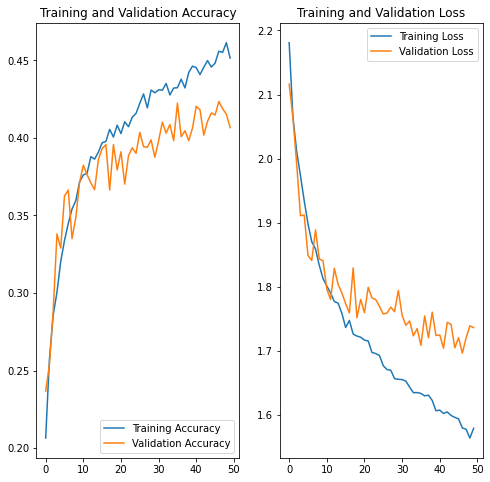

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 6.Model Evaluation.

> a.Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

> b.Print the two most incorrectly classified images foreach class in the test dataset.

In [25]:
model.evaluate(ds_test)

246/246 [==============================] - 1s 4ms/step - loss: 1.7360 - accuracy: 0.4066


[1.7359579801559448, 0.4066241979598999]

In [26]:
print('Final training loss : {}'.format(history.history['loss'][-1]))
print('Final validation loss : {}'.format(history.history['val_loss'][-1])) 
print('Final accuracy : {}'.format(history.history['accuracy'][-1]))

Final training loss : 1.578796625137329
Final validation loss : 1.7359579801559448
Final accuracy : 0.4514732360839844


In [27]:
y = np.concatenate([y for x, y in ds_test], axis=0)

In [28]:
predictions = model.predict(ds_test)
y_pred = tf.argmax(predictions, axis=-1)

In [29]:
cm = tf.math.confusion_matrix(y, y_pred)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(33.0, 0.5, 'True')

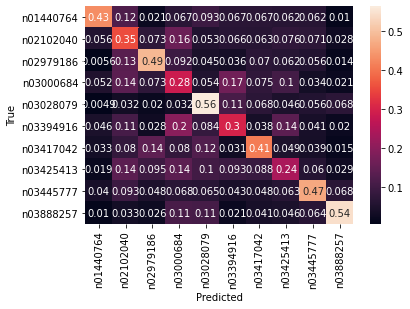

In [30]:
import seaborn as sns
sns.heatmap(
    cm, annot=True,
    xticklabels=class_names,
    yticklabels=  class_names)
plt.xlabel("Predicted")
plt.ylabel("True")

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, target_names=class_names))


              precision    recall  f1-score   support

   n01440764       0.61      0.43      0.51       387
   n02102040       0.29      0.35      0.32       395
   n02979186       0.46      0.49      0.47       357
   n03000684       0.23      0.28      0.25       386
   n03028079       0.45      0.56      0.50       409
   n03394916       0.32      0.30      0.31       394
   n03417042       0.42      0.41      0.41       389
   n03425413       0.28      0.24      0.26       419
   n03445777       0.50      0.47      0.48       399
   n03888257       0.66      0.54      0.60       390

    accuracy                           0.41      3925
   macro avg       0.42      0.41      0.41      3925
weighted avg       0.42      0.41      0.41      3925



In [32]:
report = classification_report(y, y_pred, output_dict=True)

In [33]:
cm_masked=tf.linalg.set_diag(cm,np.zeros(10))
sum=tf.reduce_sum(cm_masked, 0).numpy()
top_10=tf.math.top_k(input=sum, k=10).indices.numpy()
print("Top 2 miss-classified class:")
print(info.features["label"].int2str(top_10[-1]))
print(info.features["label"].int2str(top_10[-2]))

Top 2 miss-classified class:
n01440764
n03888257


### Hyperparameter Tuning
####Build two more additional models by changing the following hyperparameters ONE at a time. Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model.

> 1. Batch Size: Change the value of batch size in model training
> 2. Dropout: Change the position and value of dropout layer.


Write a comparison between each model and give reasons for the difference in results.

In [34]:
import gc
tf.keras.backend.clear_session()
gc.collect()

174

### Modified Model 1

In [35]:
ds_train.batch(64)
ds_test.batch(64)

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001)),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001)),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001)),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001)),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001)),
  tf.keras.layers.Dropout(0.01),
  tf.keras.layers.Dense(10,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
flatten (Flatten)            (None, 76800)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               9830528   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1

In [36]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
  optimizer=opt,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [37]:
import time
t = time.time()
epochs=50
history=model.fit(
    ds_train,
    epochs=epochs,
    batch_size=64,
    validation_data=ds_test
)
print ("Total training time: ",time.time() - t)

Epoch 1/50
592/592 [==============================] - 11s 17ms/step - loss: 2.2655 - accuracy: 0.1663 - val_loss: 2.0985 - val_accuracy: 0.2415
Epoch 2/50
592/592 [==============================] - 10s 17ms/step - loss: 2.0944 - accuracy: 0.2481 - val_loss: 2.0594 - val_accuracy: 0.2622
Epoch 3/50
592/592 [==============================] - 10s 16ms/step - loss: 2.0451 - accuracy: 0.2659 - val_loss: 1.9767 - val_accuracy: 0.2981
Epoch 4/50
592/592 [==============================] - 10s 17ms/step - loss: 1.9709 - accuracy: 0.3013 - val_loss: 1.9451 - val_accuracy: 0.3146
Epoch 5/50
592/592 [==============================] - 10s 16ms/step - loss: 1.9380 - accuracy: 0.3170 - val_loss: 1.9245 - val_accuracy: 0.3330
Epoch 6/50
592/592 [==============================] - 10s 17ms/step - loss: 1.8876 - accuracy: 0.3339 - val_loss: 1.8840 - val_accuracy: 0.3496
Epoch 7/50
592/592 [==============================] - 10s 17ms/step - loss: 1.8818 - accuracy: 0.3424 - val_loss: 1.8644 - val_accuracy:

In [38]:
model.evaluate(ds_test)

246/246 [==============================] - 1s 4ms/step - loss: 1.7135 - accuracy: 0.4181


[1.713451862335205, 0.4180891811847687]

### Modified Model 2

In [39]:
import gc
tf.keras.backend.clear_session()
gc.collect()

1787

In [40]:
ds_train.batch(32)
ds_test.batch(32)

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001)),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001)),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001)),
  tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001)),
  tf.keras.layers.Dense(10,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
flatten (Flatten)            (None, 76800)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               9830528   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1

In [41]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
  optimizer=opt,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [42]:
import time
t = time.time()
epochs=50
history=model.fit(
    ds_train,
    epochs=epochs,
    batch_size=32,
    validation_data=ds_test
)
print ("Total training time: ",time.time() - t)

Epoch 1/50
592/592 [==============================] - 11s 17ms/step - loss: 2.3529 - accuracy: 0.1257 - val_loss: 2.2403 - val_accuracy: 0.1572
Epoch 2/50
592/592 [==============================] - 10s 17ms/step - loss: 2.2450 - accuracy: 0.1543 - val_loss: 2.2326 - val_accuracy: 0.1544
Epoch 3/50
592/592 [==============================] - 10s 17ms/step - loss: 2.2395 - accuracy: 0.1517 - val_loss: 2.2208 - val_accuracy: 0.1636
Epoch 4/50
592/592 [==============================] - 10s 16ms/step - loss: 2.2316 - accuracy: 0.1538 - val_loss: 2.2132 - val_accuracy: 0.1590
Epoch 5/50
592/592 [==============================] - 10s 17ms/step - loss: 2.2258 - accuracy: 0.1632 - val_loss: 2.2164 - val_accuracy: 0.1674
Epoch 6/50
592/592 [==============================] - 10s 17ms/step - loss: 2.2229 - accuracy: 0.1635 - val_loss: 2.2395 - val_accuracy: 0.1603
Epoch 7/50
592/592 [==============================] - 10s 17ms/step - loss: 2.2223 - accuracy: 0.1516 - val_loss: 2.2158 - val_accuracy:

In [43]:
model.evaluate(ds_test)

246/246 [==============================] - 1s 4ms/step - loss: 2.1838 - accuracy: 0.1773


[2.1838066577911377, 0.17732484638690948]

Comparision of 3 models

1. Base Model: 

  --->Training set : loss: 1.5729 - accuracy: 0.4511 <br>
  --->Test Set: loss: 1.7360 - accuracy: 0.4066

<br><br>
2. Model 1: loss:

  --->Training set : loss: 1.5491 - accuracy: 0.4707 <br>
  --->Test Set: loss: 1.7135 - accuracy: 0.4181

<br><br>
3. Model 2:

  --->Training set : loss: 2.1508 - accuracy: 0.1843 <br>
  --->Test Set: loss: 2.1838 - accuracy: 0.1773


  *Base model and Model-1 is performing with similar accuracy with model-1 having slight edge over base model. Model-2 has very low accuracy for both training and test set and it seems that reason is very high dropout compared to other two. So, Model-1 is the best among these three.*